In [1]:
# uncomment below line of code if you want to calculate features and save dataframe
# this script prints the path at which dataframe with calculated features is saved.
# train.py calls the DataGenerator class to 

# %run ./train.py WMT original

# this notebook was trained on cloud compute. So use your own paths

In [2]:
import pandas as pd
import pickle 
import numpy as np
from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell


np.random.seed(2)
company_code = 'WMT'
strategy_type = 'original'
# use the path printed in above output cell after running stock_cnn.py. It's in below format
df = pd.read_csv("../outputs/fresh_rolling_train/df_"+company_code+".csv")
df['labels'] = df['labels'].astype(np.int8)
if 'dividend_amount' in df.columns:
    df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
display(df.head())

,timestamp,open,high,low,close,adjusted_close,volume,rsi_6,rsi_7,rsi_8,...,eom_19,eom_20,eom_21,eom_22,eom_23,eom_24,eom_25,eom_26,volume_delta,labels
0,2000-02-24,47.00,47.88,43.44,47.88,33.2525,19431900,10.484813,25.636878,24.162837,...,-44.898337,-44.898337,-44.898337,-44.898337,-44.898337,-44.898337,-44.898337,-44.898337,6557500.0,2
1,2000-02-25,44.31,45.31,43.63,44.50,30.9051,16908500,7.546718,7.215117,20.195163,...,-11.823639,-11.823639,-11.823639,-11.823639,-11.823639,-11.823639,-11.823639,-11.823639,-2523400.0,1
2,2000-02-28,44.56,46.94,44.56,46.19,32.0788,17836100,25.691514,17.962019,16.947352,...,17.079967,17.079967,17.079967,17.079967,17.079967,17.079967,17.079967,17.079967,927600.0,2
3,2000-02-29,47.94,49.75,47.94,48.75,33.8567,17197200,53.950905,38.433319,28.473520,...,32.574780,32.574780,32.574780,32.574780,32.574780,32.574780,32.574780,32.574780,-638900.0,2
4,2000-03-01,49.88,50.00,47.50,49.00,34.0303,10165800,56.298450,53.023610,37.866343,...,-2.336265,-2.336265,-2.336265,-2.336265,-2.336265,-2.336265,-2.336265,-2.336265,-7031400.0,2


Split data into Training, Validation and Test

In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

list_features = list(df.loc[:, 'open':'eom_26'].columns)
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_26'].values, df['labels'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

# smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
# x_train, y_train = smote.fit_resample(x_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_train))

if 0.7*x_train.shape[0] < 2500:
    train_split = 0.8
else:
    train_split = 0.7
# train_split = 0.7
print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

x_main = x_train.copy()
print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Total number of features 447
train_split = 0.7
Shape of x, y train/cv/test (2797, 447) (2797,) (1200, 447) (1200,) (1000, 447) (1000,)


Out of total 441+ features select top 'N' features (let's include base features like close, adjusted_close etc)

In [4]:
num_features = 225  # should be a perfect square
selection_method = 'all'
topk = 320 if selection_method == 'all' else num_features
# if train_split >= 0.8:
#     topk = 400
# else:
#     topk = 300

In [5]:
%%time
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")
    
if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

('open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'rsi_10', 'rsi_11', 'rsi_12', 'rsi_13', 'rsi_14', 'rsi_15', 'rsi_16', 'rsi_17', 'rsi_18', 'rsi_19', 'rsi_20', 'rsi_21', 'rsi_22', 'rsi_23', 'rsi_24', 'rsi_25', 'rsi_26', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'wr_21', 'wr_22', 'wr_23', 'wr_24', 'wr_25', 'wr_26', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_9', 'mfi_10', 'mfi_11', 'mfi_12', 'mfi_13', 'mfi_14', 'mfi_15', 'mfi_16', 'mfi_17', 'mfi_18', 'mfi_19', 'mfi_20', 'mfi_21', 'mfi_22', 'mfi_23', 'mfi_24', 'mfi_25', 'mfi_26', 'roc_6', 'roc_7', 'roc_8', 'roc_9', 'roc_10', 'roc_11', 'roc_12', 'roc_13', 'roc_14', 'roc_15', 'roc_16', 'roc_17', 'roc_18', 'roc_19', 'roc_20', 'roc_21', 'roc_22', 'roc_23', 'roc_24', 'roc_25', 'roc_26', 'cmf_6', 'cmf_7', 'cmf_8', 'cmf_9', 'cmf_10', 'cmf_11', 'cmf_12', 'cmf_13', 'cmf_14', 'cmf_15', 'cmf_16', 'cmf_17', 'cmf_18', 'cmf_19', 

In [6]:
if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)

common selected featues 285 ['roc_19', 'dpo_9', 'mfi_16', 'kst_26', 'cmo_17', 'dpo_20', 'fi_14', 'cci_26', 'rsv_19', 'wr_13', 'rsv_25', 'eom_16', 'wr_18', 'rsi_22', 'kdjk_22', 'cmo_18', 'adjusted_close', 'cci_15', 'wr_26', 'cci_14', 'mfi_25', 'dpo_10', 'cci_16', 'wr_9', 'rsv_15', 'roc_9', 'dmi_22', 'wr_10', 'fi_15', 'cmf_25', 'wr_7', 'roc_12', 'mfi_10', 'rsi_25', 'rsi_15', 'kdjk_9', 'rsi_19', 'rsi_26', 'cmo_21', 'eom_24', 'fi_11', 'rsv_10', 'wr_6', 'roc_15', 'mfi_14', 'fi_10', 'mfi_20', 'dmi_24', 'wr_23', 'roc_24', 'cci_18', 'rsv_20', 'cci_9', 'fi_18', 'rsv_9', 'kdjk_11', 'fi_13', 'wr_8', 'eom_7', 'cmo_7', 'cmf_21', 'kdjk_26', 'dmi_18', 'wr_14', 'cmo_9', 'cmo_22', 'fi_26', 'cmo_25', 'mfi_23', 'roc_7', 'cmf_6', 'fi_23', 'kdjk_10', 'rsv_22', 'kdjk_7', 'kdjk_21', 'cci_13', 'dmi_17', 'roc_11', 'kdjk_17', 'trix_12', 'rsv_8', 'roc_13', 'cmo_6', 'fi_21', 'trix_8', 'roc_17', 'rsi_8', 'cmf_12', 'kdjk_13', 'dmi_9', 'cci_6', 'cci_25', 'eom_13', 'rsi_23', 'mfi_11', 'dmi_13', 'wr_19', 'mfi_9', 'cmf

In [7]:
if selection_method == 'all':
    x_train = x_train[:, feat_idx]
    x_cv = x_cv[:, feat_idx]
    x_test = x_test[:, feat_idx]

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, 
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Shape of x, y train/cv/test (2797, 225) (2797,) (1200, 225) (1200,) (1000, 225) (1000,)


In [8]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))

percentage of class 0 = 6.399713979263496, class 1 = 6.149445834823024


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.

    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight('balanced', np.unique(y), y)
    
    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
        # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

    return sample_weights

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(f.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

C:\Users\nayak\Miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nayak\Miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nayak\Miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nayak\Miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\

In [10]:
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 1000, 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])

real class weights are [5.20856611 5.42054264 0.38116653] [0 1 2]
value_counts (array([0, 1, 2]), array([ 179,  172, 2446], dtype=int64))
Test sample_weights
[2 0 2 0 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0.38116653 5.20856611 0.38116653 5.20856611 0.38116653 0.38116653
 0.38116653 0.38116653 0.38116653 0.38116653 5.42054264 0.38116653
 0.38116653 5.42054264 0.38116653 0.38116653 0.38116653 0.38116653
 0.38116653 0.38116653 0.38116653 0.38116653 0.38116653 0.38116653
 0.38116653 0.38116653 0.38116653 0.38116653 0.38116653 0.38116653]


In [11]:
one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  # , categories='auto'
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

y_train (2797, 3)


In [12]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (2797, 15, 15, 3) (2797, 3) (1000, 15, 15, 3) (1000, 3)


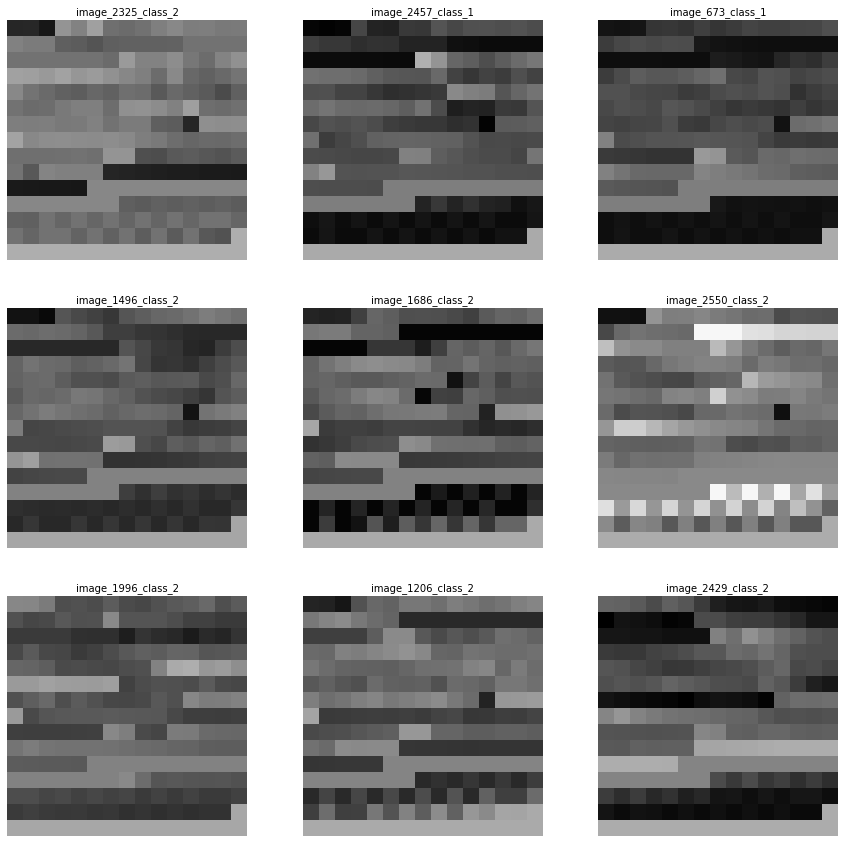

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

In [14]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

params = {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 
                                               'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 
                                               'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 
                                               'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
           'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
           'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}


In [15]:
from functools import *
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC

def f1_custom(y_true, y_pred):
    y_t = np.argmax(y_true, axis=1)
    y_p = np.argmax(y_pred, axis=1)
    f1_score(y_t, y_p, labels=None, average='weighted', sample_weight=None, zero_division='warn')

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]), 
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(x_train[0].shape[0],
                                        x_train[0].shape[1], x_train[0].shape[2]))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))
        
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        
        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))
        
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu', 
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))
    
    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    
    return model

def check_baseline(pred, y_test):
    print("size of test set", len(y_test))
    e = np.equal(pred, y_test)
    print("TP class counts", np.unique(y_test[e], return_counts=True))
    print("True class counts", np.unique(y_test, return_counts=True))
    print("Pred class counts", np.unique(pred, return_counts=True))
    holds = np.unique(y_test, return_counts=True)[1][2]  # number 'hold' predictions
    print("baseline acc:", (holds/len(y_test)*100))

In [17]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

model = create_model_cnn(params)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [18]:
import os

best_model_path = os.path.join('.', 'best_model_keras')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log_training_batch.log'), append=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
mcp = ModelCheckpoint(best_model_path, monitor='val_f1_metric', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='max', period=1)  # val_f1_metric

In [19]:
%%time
history = model.fit(x_train, y_train, epochs=params['epochs'], verbose=1,
                            batch_size=64, shuffle=True,
                            # validation_split=0.3,
                            validation_data=(x_cv, y_cv),
                            callbacks=[mcp, rlp, es]
                            , sample_weight=sample_weights)

Train on 2797 samples, validate on 1200 samples
Epoch 1/3000
2496/2797 [=========================>....] - ETA: 0s - loss: 0.8679 - acc: 0.3722 - f1_metric: 0.1928    
Epoch 00001: val_f1_metric improved from -inf to 0.11669, saving model to .\best_model_keras


OSError: Unable to create file (unable to open file: name = '.\best_model_keras', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 302)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last"

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss', 'f1', 'val_f1'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score
import seaborn as sns

model = load_model(best_model_path)
test_res = model.evaluate(x_test, y_test, verbose=0)
print("keras evaluate=", test_res)
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
check_baseline(pred_classes, y_test_classes)
conf_mat = confusion_matrix(y_test_classes, pred_classes)
print(conf_mat)
labels = [0,1,2]

f1_weighted = f1_score(y_test_classes, pred_classes, labels=None, 
         average='weighted', sample_weight=None)
print("F1 score (weighted)", f1_weighted)
print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='micro', sample_weight=None))  # weighted and micro preferred in case of imbalance
# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa --> supports multiclass; ref: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
print("cohen's Kappa", cohen_kappa_score(y_test_classes, pred_classes))

recall = []
for i, row in enumerate(conf_mat):
    recall.append(np.round(row[i]/np.sum(row), 2))
    print("Recall of class {} = {}".format(i, recall[i]))
print("Recall avg", sum(recall)/len(recall))

In [ ]:
# !conda uninstall pydot
# !conda uninstall pydotplus
# !conda uninstall graphviz

!conda install pydot
!conda install pydotplus